In [10]:
import os
import cv2
import numpy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
DIR = '/content/drive/MyDrive/Colab Notebooks/dataset/real'
os.listdir(DIR)

['human']

In [13]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DIR,transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
def denorm(img_tensor):
    return img_tensor*stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


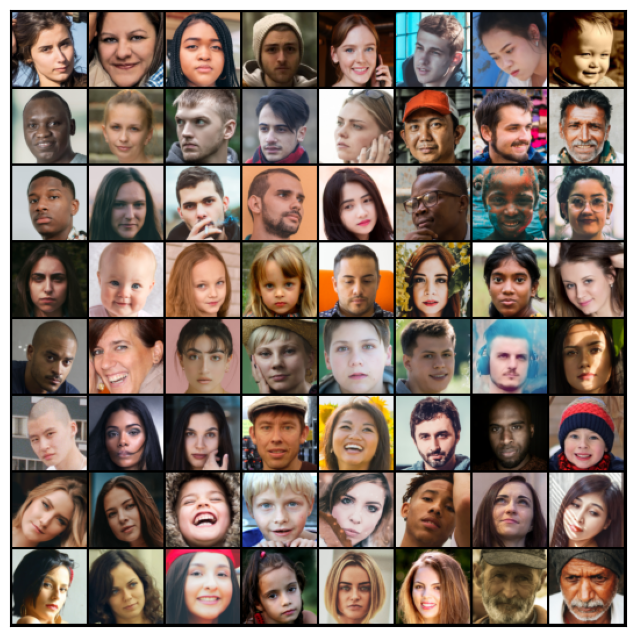

In [16]:
show_batch(train_dl)

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
train_dl = DeviceDataLoader(train_dl,device)

In [20]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
discriminator = to_device(discriminator,device)

In [22]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


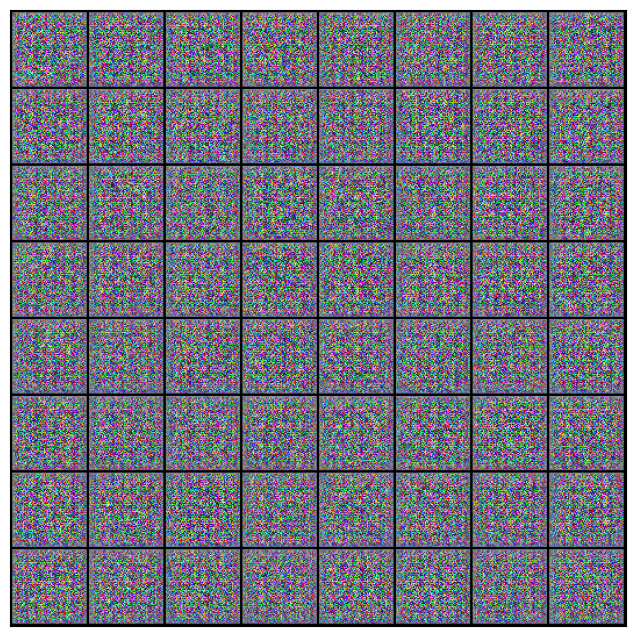

In [23]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_image = generator(xb)
print(fake_image.shape)
show_images(fake_image)

In [24]:
generator = to_device(generator, device)

In [25]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [26]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [27]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    print(fake_images.size())
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [29]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fixed_latent.shape

torch.Size([64, 128, 1, 1])

torch.Size([64, 3, 64, 64])
Saving generated-images-0000.png


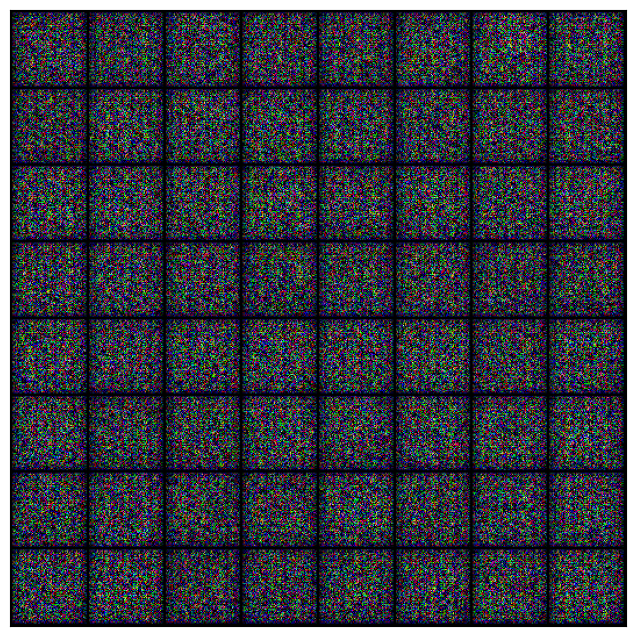

In [30]:
save_samples(0, fixed_latent)

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [32]:
lr = 0.0002
epochs = 100

In [33]:
history = fit(epochs, lr)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 6.6425, loss_d: 0.3770, real_score: 0.8524, fake_score: 0.1567
torch.Size([64, 3, 64, 64])
Saving generated-images-0001.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 12.7591, loss_d: 3.4500, real_score: 0.9390, fake_score: 0.9620
torch.Size([64, 3, 64, 64])
Saving generated-images-0002.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 11.9358, loss_d: 3.3569, real_score: 0.9400, fake_score: 0.9586
torch.Size([64, 3, 64, 64])
Saving generated-images-0003.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.4139, loss_d: 0.0955, real_score: 0.9238, fake_score: 0.0061
torch.Size([64, 3, 64, 64])
Saving generated-images-0004.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 7.7168, loss_d: 0.1734, real_score: 0.8790, fake_score: 0.0009
torch.Size([64, 3, 64, 64])
Saving generated-images-0005.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 13.5903, loss_d: 0.1747, real_score: 0.8560, fake_score: 0.0000
torch.Size([64, 3, 64, 64])
Saving generated-images-0006.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 12.9231, loss_d: 2.2218, real_score: 0.9057, fake_score: 0.8622
torch.Size([64, 3, 64, 64])
Saving generated-images-0007.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 6.9337, loss_d: 0.1093, real_score: 0.9174, fake_score: 0.0033
torch.Size([64, 3, 64, 64])
Saving generated-images-0008.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 8.9305, loss_d: 0.2011, real_score: 0.8667, fake_score: 0.0036
torch.Size([64, 3, 64, 64])
Saving generated-images-0009.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.1057, loss_d: 0.2146, real_score: 0.8462, fake_score: 0.0163
torch.Size([64, 3, 64, 64])
Saving generated-images-0010.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 5.1620, loss_d: 0.3395, real_score: 0.7604, fake_score: 0.0224
torch.Size([64, 3, 64, 64])
Saving generated-images-0011.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.5923, loss_d: 0.5055, real_score: 0.7505, fake_score: 0.1306
torch.Size([64, 3, 64, 64])
Saving generated-images-0012.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.4413, loss_d: 0.4992, real_score: 0.6703, fake_score: 0.0309
torch.Size([64, 3, 64, 64])
Saving generated-images-0013.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.3816, loss_d: 0.6776, real_score: 0.9223, fake_score: 0.4215
torch.Size([64, 3, 64, 64])
Saving generated-images-0014.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.8449, loss_d: 0.5908, real_score: 0.6516, fake_score: 0.0814
torch.Size([64, 3, 64, 64])
Saving generated-images-0015.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 5.1475, loss_d: 0.7904, real_score: 0.8767, fake_score: 0.4596
torch.Size([64, 3, 64, 64])
Saving generated-images-0016.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.8397, loss_d: 0.6259, real_score: 0.7876, fake_score: 0.2773
torch.Size([64, 3, 64, 64])
Saving generated-images-0017.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.3572, loss_d: 0.6444, real_score: 0.7677, fake_score: 0.2639
torch.Size([64, 3, 64, 64])
Saving generated-images-0018.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 2.3145, loss_d: 0.6845, real_score: 0.6280, fake_score: 0.1330
torch.Size([64, 3, 64, 64])
Saving generated-images-0019.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.1764, loss_d: 0.4949, real_score: 0.7987, fake_score: 0.1613
torch.Size([64, 3, 64, 64])
Saving generated-images-0020.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.5586, loss_d: 0.7282, real_score: 0.8851, fake_score: 0.4303
torch.Size([64, 3, 64, 64])
Saving generated-images-0021.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.8414, loss_d: 0.4074, real_score: 0.8634, fake_score: 0.2006
torch.Size([64, 3, 64, 64])
Saving generated-images-0022.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.3396, loss_d: 0.4068, real_score: 0.7689, fake_score: 0.0963
torch.Size([64, 3, 64, 64])
Saving generated-images-0023.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.3445, loss_d: 0.7714, real_score: 0.5659, fake_score: 0.0340
torch.Size([64, 3, 64, 64])
Saving generated-images-0024.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.8950, loss_d: 0.8162, real_score: 0.7852, fake_score: 0.3774
torch.Size([64, 3, 64, 64])
Saving generated-images-0025.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 6.1482, loss_d: 0.7673, real_score: 0.9023, fake_score: 0.4545
torch.Size([64, 3, 64, 64])
Saving generated-images-0026.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 1.8800, loss_d: 0.7352, real_score: 0.5941, fake_score: 0.1075
torch.Size([64, 3, 64, 64])
Saving generated-images-0027.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.8348, loss_d: 0.5767, real_score: 0.9100, fake_score: 0.3270
torch.Size([64, 3, 64, 64])
Saving generated-images-0028.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.7394, loss_d: 0.3297, real_score: 0.7952, fake_score: 0.0738
torch.Size([64, 3, 64, 64])
Saving generated-images-0029.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.9057, loss_d: 0.4482, real_score: 0.7838, fake_score: 0.1473
torch.Size([64, 3, 64, 64])
Saving generated-images-0030.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.5336, loss_d: 0.3265, real_score: 0.8487, fake_score: 0.1299
torch.Size([64, 3, 64, 64])
Saving generated-images-0031.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.8806, loss_d: 0.3284, real_score: 0.8497, fake_score: 0.1192
torch.Size([64, 3, 64, 64])
Saving generated-images-0032.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.6101, loss_d: 0.5955, real_score: 0.9152, fake_score: 0.3608
torch.Size([64, 3, 64, 64])
Saving generated-images-0033.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.8979, loss_d: 0.8396, real_score: 0.9357, fake_score: 0.4776
torch.Size([64, 3, 64, 64])
Saving generated-images-0034.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.0812, loss_d: 0.4577, real_score: 0.8370, fake_score: 0.2039
torch.Size([64, 3, 64, 64])
Saving generated-images-0035.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.4565, loss_d: 0.6107, real_score: 0.7948, fake_score: 0.2441
torch.Size([64, 3, 64, 64])
Saving generated-images-0036.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 6.4592, loss_d: 1.1558, real_score: 0.9792, fake_score: 0.6257
torch.Size([64, 3, 64, 64])
Saving generated-images-0037.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.9378, loss_d: 0.7107, real_score: 0.9282, fake_score: 0.4312
torch.Size([64, 3, 64, 64])
Saving generated-images-0038.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.2077, loss_d: 0.6206, real_score: 0.8512, fake_score: 0.3180
torch.Size([64, 3, 64, 64])
Saving generated-images-0039.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.2914, loss_d: 0.5111, real_score: 0.7789, fake_score: 0.1948
torch.Size([64, 3, 64, 64])
Saving generated-images-0040.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.9511, loss_d: 0.5104, real_score: 0.8666, fake_score: 0.2706
torch.Size([64, 3, 64, 64])
Saving generated-images-0041.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.9621, loss_d: 1.4489, real_score: 0.3364, fake_score: 0.0035
torch.Size([64, 3, 64, 64])
Saving generated-images-0042.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.0600, loss_d: 0.5285, real_score: 0.7275, fake_score: 0.1128
torch.Size([64, 3, 64, 64])
Saving generated-images-0043.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.6757, loss_d: 0.6098, real_score: 0.6279, fake_score: 0.0269
torch.Size([64, 3, 64, 64])
Saving generated-images-0044.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.7939, loss_d: 0.4729, real_score: 0.7534, fake_score: 0.1282
torch.Size([64, 3, 64, 64])
Saving generated-images-0045.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.1396, loss_d: 0.9172, real_score: 0.5161, fake_score: 0.0212
torch.Size([64, 3, 64, 64])
Saving generated-images-0046.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 2.8694, loss_d: 0.5893, real_score: 0.6708, fake_score: 0.0493
torch.Size([64, 3, 64, 64])
Saving generated-images-0047.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 4.0502, loss_d: 0.4975, real_score: 0.8098, fake_score: 0.2045
torch.Size([64, 3, 64, 64])
Saving generated-images-0048.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 2.7629, loss_d: 0.9123, real_score: 0.5097, fake_score: 0.0118
torch.Size([64, 3, 64, 64])
Saving generated-images-0049.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 3.8363, loss_d: 1.0839, real_score: 0.4536, fake_score: 0.0259
torch.Size([64, 3, 64, 64])
Saving generated-images-0050.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.2872, loss_d: 0.4918, real_score: 0.7384, fake_score: 0.1257
torch.Size([64, 3, 64, 64])
Saving generated-images-0051.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.7915, loss_d: 0.4355, real_score: 0.8036, fake_score: 0.1599
torch.Size([64, 3, 64, 64])
Saving generated-images-0052.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.5090, loss_d: 0.3986, real_score: 0.7729, fake_score: 0.0848
torch.Size([64, 3, 64, 64])
Saving generated-images-0053.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.7386, loss_d: 0.3370, real_score: 0.8632, fake_score: 0.1451
torch.Size([64, 3, 64, 64])
Saving generated-images-0054.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.6456, loss_d: 0.4028, real_score: 0.9355, fake_score: 0.2495
torch.Size([64, 3, 64, 64])
Saving generated-images-0055.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.4938, loss_d: 0.4638, real_score: 0.7137, fake_score: 0.0635
torch.Size([64, 3, 64, 64])
Saving generated-images-0056.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.3492, loss_d: 0.3881, real_score: 0.8544, fake_score: 0.1771
torch.Size([64, 3, 64, 64])
Saving generated-images-0057.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.3781, loss_d: 0.4951, real_score: 0.7881, fake_score: 0.1852
torch.Size([64, 3, 64, 64])
Saving generated-images-0058.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 9.3351, loss_d: 1.4514, real_score: 0.9653, fake_score: 0.6880
torch.Size([64, 3, 64, 64])
Saving generated-images-0059.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.6203, loss_d: 0.5933, real_score: 0.9205, fake_score: 0.3609
torch.Size([64, 3, 64, 64])
Saving generated-images-0060.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.7988, loss_d: 0.3754, real_score: 0.8272, fake_score: 0.1442
torch.Size([64, 3, 64, 64])
Saving generated-images-0061.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.5696, loss_d: 0.4966, real_score: 0.8694, fake_score: 0.2575
torch.Size([64, 3, 64, 64])
Saving generated-images-0062.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 5.8842, loss_d: 0.6290, real_score: 0.8990, fake_score: 0.3659
torch.Size([64, 3, 64, 64])
Saving generated-images-0063.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.1252, loss_d: 0.8189, real_score: 0.5568, fake_score: 0.0297
torch.Size([64, 3, 64, 64])
Saving generated-images-0064.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 2.4160, loss_d: 0.5650, real_score: 0.6471, fake_score: 0.0421
torch.Size([64, 3, 64, 64])
Saving generated-images-0065.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.5167, loss_d: 0.5853, real_score: 0.7672, fake_score: 0.2154
torch.Size([64, 3, 64, 64])
Saving generated-images-0066.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.1589, loss_d: 0.9532, real_score: 0.4865, fake_score: 0.0342
torch.Size([64, 3, 64, 64])
Saving generated-images-0067.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.4963, loss_d: 0.8338, real_score: 0.8322, fake_score: 0.3972
torch.Size([64, 3, 64, 64])
Saving generated-images-0068.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.8624, loss_d: 0.6493, real_score: 0.7814, fake_score: 0.2782
torch.Size([64, 3, 64, 64])
Saving generated-images-0069.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.9342, loss_d: 0.7503, real_score: 0.9238, fake_score: 0.4451
torch.Size([64, 3, 64, 64])
Saving generated-images-0070.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.7671, loss_d: 0.6252, real_score: 0.5989, fake_score: 0.0150
torch.Size([64, 3, 64, 64])
Saving generated-images-0071.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 5.4865, loss_d: 0.6441, real_score: 0.8808, fake_score: 0.3578
torch.Size([64, 3, 64, 64])
Saving generated-images-0072.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.8577, loss_d: 0.9615, real_score: 0.4870, fake_score: 0.0171
torch.Size([64, 3, 64, 64])
Saving generated-images-0073.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 3.1266, loss_d: 0.7544, real_score: 0.6810, fake_score: 0.2253
torch.Size([64, 3, 64, 64])
Saving generated-images-0074.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.5593, loss_d: 0.4653, real_score: 0.8129, fake_score: 0.1981
torch.Size([64, 3, 64, 64])
Saving generated-images-0075.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.2856, loss_d: 0.9097, real_score: 0.4865, fake_score: 0.0180
torch.Size([64, 3, 64, 64])
Saving generated-images-0076.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 2.1792, loss_d: 2.2662, real_score: 0.2035, fake_score: 0.0042
torch.Size([64, 3, 64, 64])
Saving generated-images-0077.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.5599, loss_d: 0.7552, real_score: 0.6149, fake_score: 0.1286
torch.Size([64, 3, 64, 64])
Saving generated-images-0078.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.0628, loss_d: 1.9080, real_score: 0.2224, fake_score: 0.0070
torch.Size([64, 3, 64, 64])
Saving generated-images-0079.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 2.4553, loss_d: 0.8227, real_score: 0.5215, fake_score: 0.0565
torch.Size([64, 3, 64, 64])
Saving generated-images-0080.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.5618, loss_d: 0.3986, real_score: 0.8892, fake_score: 0.2172
torch.Size([64, 3, 64, 64])
Saving generated-images-0081.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 5.9743, loss_d: 0.7127, real_score: 0.9026, fake_score: 0.4153
torch.Size([64, 3, 64, 64])
Saving generated-images-0082.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.5904, loss_d: 0.5242, real_score: 0.8464, fake_score: 0.2626
torch.Size([64, 3, 64, 64])
Saving generated-images-0083.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.0432, loss_d: 1.7880, real_score: 0.2481, fake_score: 0.0035
torch.Size([64, 3, 64, 64])
Saving generated-images-0084.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 2.5332, loss_d: 0.6555, real_score: 0.6527, fake_score: 0.0730
torch.Size([64, 3, 64, 64])
Saving generated-images-0085.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.1715, loss_d: 0.5580, real_score: 0.7618, fake_score: 0.1878
torch.Size([64, 3, 64, 64])
Saving generated-images-0086.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.9304, loss_d: 0.7738, real_score: 0.6929, fake_score: 0.2693
torch.Size([64, 3, 64, 64])
Saving generated-images-0087.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.5468, loss_d: 0.6105, real_score: 0.8471, fake_score: 0.3285
torch.Size([64, 3, 64, 64])
Saving generated-images-0088.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 2.7167, loss_d: 0.6165, real_score: 0.8784, fake_score: 0.3299
torch.Size([64, 3, 64, 64])
Saving generated-images-0089.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.8326, loss_d: 0.8730, real_score: 0.8783, fake_score: 0.4753
torch.Size([64, 3, 64, 64])
Saving generated-images-0090.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.2570, loss_d: 0.8393, real_score: 0.7817, fake_score: 0.3823
torch.Size([64, 3, 64, 64])
Saving generated-images-0091.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.0136, loss_d: 0.6519, real_score: 0.6315, fake_score: 0.0919
torch.Size([64, 3, 64, 64])
Saving generated-images-0092.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.5628, loss_d: 0.5579, real_score: 0.8614, fake_score: 0.3036
torch.Size([64, 3, 64, 64])
Saving generated-images-0093.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 3.8889, loss_d: 0.6383, real_score: 0.8963, fake_score: 0.3684
torch.Size([64, 3, 64, 64])
Saving generated-images-0094.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 2.8996, loss_d: 0.5008, real_score: 0.8461, fake_score: 0.2487
torch.Size([64, 3, 64, 64])
Saving generated-images-0095.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 2.4298, loss_d: 0.5295, real_score: 0.6957, fake_score: 0.0940
torch.Size([64, 3, 64, 64])
Saving generated-images-0096.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.2797, loss_d: 0.5498, real_score: 0.7634, fake_score: 0.2030
torch.Size([64, 3, 64, 64])
Saving generated-images-0097.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.9420, loss_d: 0.4941, real_score: 0.6806, fake_score: 0.0479
torch.Size([64, 3, 64, 64])
Saving generated-images-0098.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.3405, loss_d: 0.3700, real_score: 0.9452, fake_score: 0.2467
torch.Size([64, 3, 64, 64])
Saving generated-images-0099.png


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 2.1560, loss_d: 0.5947, real_score: 0.7435, fake_score: 0.2094
torch.Size([64, 3, 64, 64])
Saving generated-images-0100.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

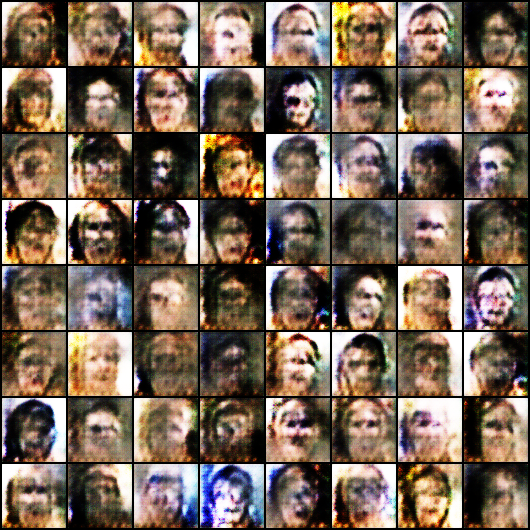

In [35]:
from IPython.display import Image
Image('./generated/generated-images-0060.png')

In [36]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

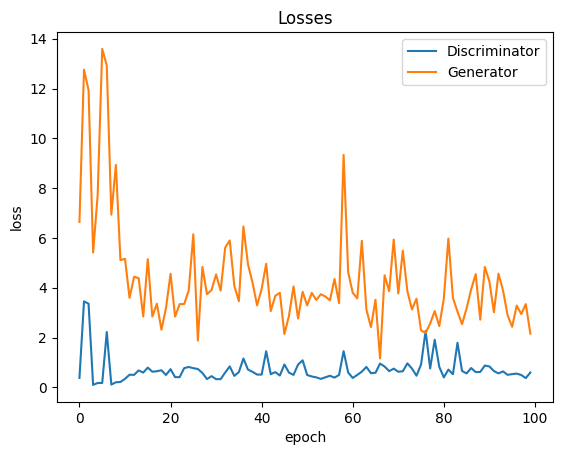

In [37]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

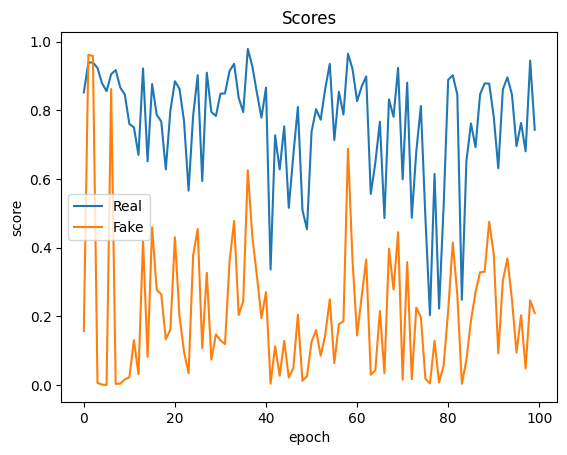

In [38]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');